# Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as torch_nnf

from typing import Union, Iterable
from pathlib import Path
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.utils import degree

from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split

# Consts

In [2]:
RANDOM_STATE = 42
TEST_RATIO = 0.2

EPOCHS = 10
BATCH_SIZE = 1024
DECAY = 0.0001
K = 20

torch.manual_seed(RANDOM_STATE)

# Data loading & preprocessing

In [3]:
merged_data = pd.read_csv("../data/interim/merged.csv", sep="\t")
merged_data.head()

,user_id,item_id,rating,timestamp,age,gender,occupation,zip code,movie_title,release date,...,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,user_id_new,item_id_new
0,196,242,3,1997-12-04 15:55:49,49,M,writer,55105,Kolya (1996),24-Jan-1997,...,0,0,0,0,0,0,0,0,195,241
1,305,242,5,1998-02-01 04:37:08,23,M,programmer,94086,Kolya (1996),24-Jan-1997,...,0,0,0,0,0,0,0,0,304,241
2,6,242,4,1997-12-28 00:16:10,42,M,executive,98101,Kolya (1996),24-Jan-1997,...,0,0,0,0,0,0,0,0,5,241
3,234,242,4,1998-03-27 21:14:21,60,M,retired,94702,Kolya (1996),24-Jan-1997,...,0,0,0,0,0,0,0,0,233,241
4,63,242,3,1997-10-01 23:06:30,31,M,marketing,75240,Kolya (1996),24-Jan-1997,...,0,0,0,0,0,0,0,0,62,241


In [4]:
n_users: int = merged_data.user_id.nunique()
n_items: int = merged_data.item_id.nunique()

In [5]:
merged_data_good = merged_data[merged_data['rating'] > 2]  # Only liked movies

In [6]:
def get_train_val_split(data: pd.DataFrame) -> tuple[pd.DataFrame, pd.DataFrame]:
    """
    Split the input DataFrame into training and testing sets, considering unique users and movies.
    Any user_id in the test set would be present in the training set. The same is applicable to item_id.

    Parameters:
        data (pd.DataFrame): The input DataFrame containing user-item interaction data.

    Returns:
        tuple[pd.DataFrame, pd.DataFrame]: A tuple containing two DataFrames - the training set and the testing set.
    """
    data = data.copy()
    data['id'] = range(len(data))
    test_size = int(TEST_RATIO * len(data))

    # Save all unique users
    all_no_user_cols = [i for i in data.columns if i != 'user_id']
    first_user_entries = data.groupby('user_id')[all_no_user_cols].first().reset_index()
    first_user_entries = first_user_entries[data.columns]

    data = data[
        ~data['id'].isin(first_user_entries['id'].values)
    ]

    # Save all unique movies
    all_no_item_cols = [i for i in data.columns if i != 'item_id']
    first_movie_entries = data.groupby('item_id')[all_no_item_cols].first().reset_index()
    first_movie_entries = first_movie_entries[data.columns]

    data = data[
        ~data['id'].isin(first_movie_entries['id'].values)
    ]

    # Split data
    train, test = train_test_split(
        data.values,
        test_size=test_size,
        random_state=RANDOM_STATE
    )
    train_data = pd.DataFrame(train, columns=data.columns)
    train_data = pd.concat([train_data, first_user_entries, first_movie_entries], axis=0)
    test_data = pd.DataFrame(test, columns=data.columns)

    train_data = train_data.drop('id', axis=1)
    test_data = test_data.drop('id', axis=1)
    data = data.drop('id', axis=1)

    # Restore types
    for col in data.columns:
        train_data[col] = train_data[col].astype(data[col].dtype)
        test_data[col] = test_data[col].astype(data[col].dtype)

    return train_data, test_data

In [7]:
train_df, test_df = get_train_val_split(merged_data_good)
assert len(train_df) + len(test_df) == len(merged_data_good)

In [8]:
train_df.head()

,user_id,item_id,rating,timestamp,age,gender,occupation,zip code,movie_title,release date,...,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,user_id_new,item_id_new
0,590,127,4,1997-11-13 16:47:25,50,M,educator,82435,"Godfather, The (1972)",01-Jan-1972,...,0,0,0,0,0,0,0,0,589,126
1,693,318,4,1997-09-28 21:28:12,43,F,healthcare,85210,Schindler's List (1993),01-Jan-1993,...,0,0,0,0,0,0,1,0,692,317
2,532,118,4,1998-02-28 03:00:13,20,M,student,92705,Twister (1996),10-May-1996,...,0,0,0,0,0,1,0,0,531,117
3,582,328,3,1997-12-24 10:49:15,17,M,student,93003,Conspiracy Theory (1997),08-Aug-1997,...,0,0,1,1,0,1,0,0,581,327
4,109,161,3,1997-11-26 19:32:36,29,M,other,55423,Top Gun (1986),01-Jan-1986,...,0,0,0,1,0,0,0,0,108,160


# Batch function & Edge index function

In [9]:
def get_not_in(x: Iterable[int], low: int, high: int) -> int:
    """
    Generate a random integer within a specified range that is not present in the given iterable.

    Parameters:
        x (Iterable[int]): The iterable containing integers.
        low (int): The lower bound of the range (inclusive).
        high (int): The upper bound of the range (exclusive).

    Returns:
        int: A random integer within the specified range that is not present in the input iterable.
    """
    candidate = np.random.randint(low, high)
    while candidate in x:
        candidate = np.random.randint(low, high)
    return candidate


def get_batch(data: pd.DataFrame,
              batch_size: int,
              n_usr: int,
              n_itm: int,
              dev: Union[torch.device, str] = 'cpu') -> tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
    """
    Generate a batch of training data for a recommendation system.

    Parameters:
        data (pd.DataFrame): The input DataFrame containing user-item interaction data.
        batch_size (int): The number of samples to include in the batch.
        n_usr (int): The number of unique users in the dataset.
        n_itm (int): The number of unique items in the dataset.
        dev (Union[torch.device, str]): The device on which to place the generated tensors (default is 'cpu').

    Returns:
        Tuple[torch.Tensor, torch.Tensor, torch.Tensor]: A tuple containing three tensors representing chosen users,
        positive items, and negative items for the recommendation system training batch.
    """
    users_liked_items = data.groupby('user_id_new')['item_id_new'].apply(list).reset_index()
    indices: np.ndarray = np.arange(0, n_usr, 1)

    chosen_users = np.random.choice(indices, batch_size, replace=n_usr < batch_size)
    chosen_users.sort()

    users_liked_items = pd.merge(
        users_liked_items, 
        pd.DataFrame(chosen_users, columns=['user_id_new']), 
        how='right', 
        on='user_id_new'
    )
    pos_items = users_liked_items['item_id_new'].apply(lambda x: np.random.choice(x)).values + n_usr
    neg_items = users_liked_items['item_id_new'].apply(lambda x: get_not_in(x, 0, n_itm)).values + n_usr

    return (
        torch.LongTensor(chosen_users).to(dev),
        torch.LongTensor(pos_items).to(dev),
        torch.LongTensor(neg_items).to(dev),
    )

In [10]:
get_batch(train_df, 10, n_users, n_items)

(tensor([156, 310, 359, 412, 466, 615, 626, 639, 700, 822]),
 tensor([1958, 1145, 1981, 1270, 1240, 1265,  951, 1508, 1239, 1176]),
 tensor([1814, 1487, 1252, 1017, 2168, 2410, 1394, 1645, 2300, 1833]))

In [11]:
def get_edge_index(data: pd.DataFrame,
                   n_usr: int,
                   dev: Union[torch.device, str] = 'cpu') -> torch.Tensor:
    """
    Generate the edge index tensor for a bipartite graph representing user-item interactions.

    Parameters:
        data (pd.DataFrame): The input DataFrame containing user-item interaction data.
        n_usr (int): The number of unique users in the dataset.
        dev (Union[torch.device, str]): The device on which to place the generated tensor (default is 'cpu').

    Returns:
        torch.Tensor: The edge index tensor for the bipartite graph, representing user-item interactions.
    """
    # Convert user and item IDs to PyTorch LongTensors
    u_t = torch.LongTensor(data.user_id_new.values)
    i_t = torch.LongTensor(data.item_id_new.values) + n_usr

    # Create the edge index tensor by stacking user and item tensors
    train_edge_index = torch.stack(
        (
            torch.cat([u_t, i_t]),
            torch.cat([i_t, u_t])
        )
    ).to(dev)
    return train_edge_index

In [12]:
get_edge_index(train_df, n_users)

tensor([[ 589,  692,  531,  ..., 2621, 2623, 2624],
        [1069, 1260, 1060,  ...,  862,  895,  915]])

# Model

In [13]:
class LightGNNConv(MessagePassing):
    """
    Implementation of a LightGNN convolutional layer for graph neural networks.
    """

    def __init__(self):
        super().__init__(aggr='add')

    def forward(self, x, edge_index):
        """
        Perform a forward pass through the LightGNNConv layer.

        Parameters:
            x (torch.Tensor): The input node features.
            edge_index (torch.Tensor): The edge index tensor representing the graph connectivity.

        Returns:
            torch.Tensor: The output tensor after applying the LightGNNConv layer.
        """
        # Compute normalization
        from_, to_ = edge_index
        deg = degree(to_, x.size(0), dtype=x.dtype)
        deg_inv_sqrt = deg.pow(-0.5)
        deg_inv_sqrt[deg_inv_sqrt == float('inf')] = 0
        norm = deg_inv_sqrt[from_] * deg_inv_sqrt[to_]

        # Start propagating messages (no update after aggregation)
        return self.propagate(edge_index, x=x, norm=norm)

    def message(self, x_j, norm):
        """
        Define the message function for the LightGNNConv layer.

        Parameters:
            x_j (torch.Tensor): The input node features of neighboring nodes.
            norm (torch.Tensor): The normalization coefficients.

        Returns:
            torch.Tensor: The scaled and normalized message.
        """
        return norm.view(-1, 1) * x_j

In [14]:
class RecSysGNN(nn.Module):
    """
    Graph Neural Network model for recommendation systems.

    Parameters:
        latent_dim (int): The dimensionality of the embedding.
        n_layers (int): The number of layers in the GNN.
        n_usr (int): The number of unique users in the dataset.
        n_itm (int): The number of unique items in the dataset.
    """

    def __init__(
            self,
            latent_dim: int,
            n_layers: int,
            n_usr: int,
            n_itm: int
    ):
        super(RecSysGNN, self).__init__()
        self.embedding = nn.Embedding(n_usr + n_itm, latent_dim)
        self.conv_s = nn.ModuleList(LightGNNConv() for _ in range(n_layers))
        self.init_parameters()

    def init_parameters(self):
        """
        Initialize the parameters of the embedding layer using normal distribution with a standard deviation of 0.1.
        """
        # Authors of LightGCN report higher results with normal initialization
        nn.init.normal_(self.embedding.weight, std=0.1)

    def forward(self, edge_index: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor]:
        """
        Perform a forward pass through the RecSysGNN model.

        Parameters:
            edge_index (torch.Tensor): The edge index tensor representing the graph connectivity.

        Returns:
            Tuple[torch.Tensor, torch.Tensor]: A tuple containing the initial embeddings and the final embeddings.
        """
        emb0 = self.embedding.weight
        emb_s = [emb0]

        emb = emb0
        for conv in self.conv_s:
            emb = conv(x=emb, edge_index=edge_index)
            emb_s.append(emb)

        out = torch.mean(torch.stack(emb_s, dim=0), dim=0)

        return emb0, out

    def encode_minibatch(self,
                         users: torch.Tensor,
                         pos_items: torch.Tensor,
                         neg_items: torch.Tensor,
                         edge_index: torch.Tensor) -> tuple[torch.Tensor, ...]:
        """
        Encode a minibatch of users, positive items, and negative items using the RecSysGNN model.

        Parameters:
            users (torch.Tensor): Indices of users in the minibatch.
            pos_items (torch.Tensor): Indices of positive items in the minibatch.
            neg_items (torch.Tensor): Indices of negative items in the minibatch.
            edge_index (torch.Tensor): The edge index tensor representing the graph connectivity.

        Returns:
            Tuple[torch.Tensor, ...]: A tuple containing embeddings for users, positive items, and negative items,
            both in the initial and final representations.
        """
        emb0, out = self(edge_index)
        return (
            out[users],
            out[pos_items],
            out[neg_items],
            emb0[users],
            emb0[pos_items],
            emb0[neg_items]
        )

# Loss and metrics

In [15]:
def compute_bpr_loss(users: torch.Tensor,
                     users_emb: torch.Tensor,
                     pos_emb: torch.Tensor,
                     neg_emb: torch.Tensor,
                     user_emb_0: torch.Tensor,
                     pos_emb_0: torch.Tensor,
                     neg_emb_0: torch.Tensor, ) -> tuple[torch.Tensor, torch.Tensor]:
    """
    Compute BPR (Bayesian Personalized Ranking) loss and regularization loss.

    Parameters:
        users (torch.Tensor): Indices of users in the minibatch.
        users_emb (torch.Tensor): Embeddings for users.
        pos_emb (torch.Tensor): Embeddings for positive items.
        neg_emb (torch.Tensor): Embeddings for negative items.
        user_emb_0 (torch.Tensor): Initial embeddings for users.
        pos_emb_0 (torch.Tensor): Initial embeddings for positive items.
        neg_emb_0 (torch.Tensor): Initial embeddings for negative items.

    Returns:
        Tuple[torch.Tensor, torch.Tensor]: A tuple containing BPR loss and regularization loss.
    """
    # compute loss from initial embeddings, used for regularization
    reg_loss = (1 / 2) * (
            user_emb_0.norm().pow(2) +
            pos_emb_0.norm().pow(2) +
            neg_emb_0.norm().pow(2)
    ) / float(len(users))

    # compute BPR loss from user, positive item, and negative item embeddings
    pos_scores = torch.mul(users_emb, pos_emb).sum(dim=1)
    neg_scores = torch.mul(users_emb, neg_emb).sum(dim=1)

    bpr_loss = torch.mean(torch_nnf.softplus(neg_scores - pos_scores))

    return bpr_loss, reg_loss

In [16]:
def compute_metrics(user_embs: torch.Tensor,
                    item_embs: torch.Tensor,
                    n_usr: int,
                    n_itm: int,
                    train_data: pd.DataFrame,
                    test_data: pd.DataFrame,
                    top_k: int,
                    dev: Union[torch.device, str] = "cpu"):
    """
    Compute recall and precision metrics for a recommendation system.

    Parameters:
        user_embs (torch.Tensor): Embeddings for users.
        item_embs (torch.Tensor): Embeddings for items.
        n_usr (int): The number of unique users in the dataset.
        n_itm (int): The number of unique items in the dataset.
        train_data (pd.DataFrame): The training data DataFrame.
        test_data (pd.DataFrame): The test data DataFrame.
        top_k (int): The number of top recommendations to consider.
        dev (Union[torch.device, str]): The device on which to perform the computation (default is "cpu").

    Returns:
        Tuple[float, float]: A tuple containing the average recall and precision values.
    """
    if isinstance(dev, str):
        dev = torch.device(dev)

    relevance_score = torch.matmul(user_embs, item_embs.T)

    # create dense tensor of all user-item interactions
    connections = torch.stack(
        (
            torch.LongTensor(train_data['user_id_new'].values),
            torch.LongTensor(train_data['item_id_new'].values)
        )
    )
    values = torch.ones((len(train_data),), dtype=torch.float64)
    interactions_t = torch.sparse_coo_tensor(
        connections,
        values,
        (n_usr, n_itm)
    ).to_dense().to(dev)

    # mask out training user-item interactions from metric computation
    relevance_score = torch.mul(relevance_score, (1 - interactions_t))

    top_k_relevance_indices = torch.topk(relevance_score, top_k).indices
    if dev.type == "cuda":
        top_k_relevance_indices = top_k_relevance_indices.cpu()
    top_k_relevance_indices_df = pd.DataFrame(
        top_k_relevance_indices.numpy(),
        columns=[f'top_idx_{x + 1}' for x in range(top_k)]
    )
    top_k_relevance_indices_df['user_id_new'] = top_k_relevance_indices_df.index
    top_k_relevance_indices_df['top_rvt_item'] = top_k_relevance_indices_df[
        [f'top_idx_{x + 1}' for x in range(top_k)]
    ].values.tolist()
    top_k_relevance_indices_df = top_k_relevance_indices_df[['user_id_new', 'top_rvt_item']]

    test_interacted_items = test_data.groupby('user_id_new')['item_id_new'].apply(list).reset_index()
    metrics_df = pd.merge(
        test_interacted_items,
        top_k_relevance_indices_df,
        how='left',
        on='user_id_new'
    )
    metrics_df['intersection_itm'] = [
        list(set(a).intersection(b))
        for a, b in zip(metrics_df.item_id_new, metrics_df.top_rvt_item)
    ]

    metrics_df['recall'] = metrics_df.apply(lambda x: len(x['intersection_itm']) / len(x['item_id_new']), axis=1)
    metrics_df['precision'] = metrics_df.apply(lambda x: len(x['intersection_itm']) / top_k, axis=1)

    return metrics_df['recall'].mean(), metrics_df['precision'].mean()

# Training

In [17]:
def train_and_eval(train_model: RecSysGNN,
                   optim: torch.optim.Optimizer,
                   train_data: pd.DataFrame,
                   test_data: pd.DataFrame,
                   epochs: int,
                   n_usr: int,
                   n_itm: int,
                   top_k: int,
                   dev: Union[torch.device, str] = "cpu",
                   ckpt_path_recall: Union[str, Path, None] = None,
                   ckpt_path_precision: Union[str, Path, None] = None):
    """
    Train and evaluate a recommendation system using a graph neural network.

    Parameters:
        train_model (RecSysGNN): The recommendation system model.
        optim (torch.optim.Optimizer): The optimizer for training the model.
        train_data (pd.DataFrame): The training data DataFrame.
        test_data (pd.DataFrame): The test data DataFrame.
        epochs (int): The number of training epochs.
        n_usr (int): The number of unique users in the dataset.
        n_itm (int): The number of unique items in the dataset.
        top_k (int): The number of top recommendations to consider for evaluation.
        dev (Union[torch.device, str]): The device on which to perform the computation (default is "cpu").
        ckpt_path_recall (Union[str, Path, None]): The path to save the model checkpoint based on recall (default is None).
        ckpt_path_precision (Union[str, Path, None]): The path to save the model checkpoint based on precision (default is None).

    Returns:
        Tuple[list, list, list, list, list]: A tuple containing lists of loss, BPR loss, regularization loss, recall, and precision values.
    """
    loss_list_epoch = []
    bpr_loss_list_epoch = []
    reg_loss_list_epoch = []

    recall_list = []
    precision_list = []
    train_edge_index = get_edge_index(train_data, n_usr, dev)

    best_recall = 0
    best_precision = 0

    for epoch in range(epochs):
        n_batch = int(len(train_data) / BATCH_SIZE)

        # progress bar
        progress_train = tqdm(
            range(1, n_batch + 1), 
            desc=f"Epoch {epoch + 1}/{epochs}", 
            unit="batch",
            total=n_batch
        )
        final_loss_total = 0
        bpr_loss_total = 0
        reg_loss_total = 0

        # Train
        train_model.train()
        for batch_idx in progress_train:
            optim.zero_grad()

            users, pos_items, neg_items = get_batch(train_data, BATCH_SIZE, n_usr, n_itm, dev)
            (
                users_emb,
                pos_emb,
                neg_emb,
                user_emb_0,
                pos_emb_0,
                neg_emb_0
            ) = train_model.encode_minibatch(
                users,
                pos_items,
                neg_items,
                train_edge_index
            )

            bpr_loss, reg_loss = compute_bpr_loss(
                users, users_emb, pos_emb, neg_emb,
                user_emb_0, pos_emb_0, neg_emb_0
            )

            bpr_loss_total += bpr_loss.item()
            reg_loss_total += reg_loss.item()

            reg_loss = DECAY * reg_loss
            final_loss = bpr_loss + reg_loss
            
            final_loss_total += final_loss.item()

            final_loss.backward()
            optim.step()

            progress_train.set_postfix(
                **{
                    "final loss": final_loss_total / batch_idx, 
                    "bpr loss": bpr_loss_total / batch_idx,
                    "reg loss": reg_loss_total / batch_idx, 
                }
            )

        train_model.eval()
        with torch.no_grad():
            _, out = train_model(train_edge_index)
            emb_u, emb_i = torch.split(out, [n_usr, n_itm])
            test_top_k_recall, test_top_k_precision = compute_metrics(
                emb_u, emb_i, n_usr, n_itm, train_data, test_data, top_k, dev
            )

        loss_list_epoch.append(round(final_loss_total / n_batch, 4))
        bpr_loss_list_epoch.append(round(bpr_loss_total / n_batch, 4))
        reg_loss_list_epoch.append(round(reg_loss_total / n_batch, 4))

        recall_list.append(round(test_top_k_recall, 4))
        precision_list.append(round(test_top_k_precision, 4))

        print(
            f"Validation, "
            f"Top K Recall: {test_top_k_recall:.4f}, "
            f"Top K Precision: {test_top_k_precision:.4f}"
        )

        if ckpt_path_recall and best_recall < test_top_k_recall:
            best_recall = test_top_k_recall
            torch.save(train_model.state_dict(), ckpt_path_recall)
        if ckpt_path_precision and best_precision < test_top_k_precision:
            best_precision = test_top_k_precision
            torch.save(train_model.state_dict(), ckpt_path_precision)

    return (
        loss_list_epoch,
        bpr_loss_list_epoch,
        reg_loss_list_epoch,
        recall_list,
        precision_list
    )

In [18]:
device = "cuda" if torch.cuda.is_available() else "cpu"
light_gcn = RecSysGNN(
    latent_dim=64,
    n_layers=3,
    n_usr=n_users,
    n_itm=n_items,
)
light_gcn.to(device)

optimizer = torch.optim.Adam(light_gcn.parameters())
print(device)
print("Size of Learnable Embedding:", [x.shape for x in list(light_gcn.parameters())])

cuda
Size of Learnable Embedding: [torch.Size([2625, 64])]


In [19]:
light_loss, light_bpr, light_reg, light_recall, light_precision = train_and_eval(
    train_model=light_gcn,
    optim=optimizer,
    train_data=train_df,
    test_data=test_df,
    epochs=EPOCHS,
    n_usr=n_users,
    n_itm=n_items,
    top_k=K,
    dev=device,
)

Epoch 1/10:   0%|          | 0/64 [00:00<?, ?batch/s]

Validation, Top K Recall: 0.1858, Top K Precision: 0.1282


Epoch 2/10:   0%|          | 0/64 [00:00<?, ?batch/s]

Validation, Top K Recall: 0.1846, Top K Precision: 0.1251


Epoch 3/10:   0%|          | 0/64 [00:00<?, ?batch/s]

Validation, Top K Recall: 0.1842, Top K Precision: 0.1228


Epoch 4/10:   0%|          | 0/64 [00:00<?, ?batch/s]

Validation, Top K Recall: 0.1847, Top K Precision: 0.1208


Epoch 5/10:   0%|          | 0/64 [00:00<?, ?batch/s]

Validation, Top K Recall: 0.1859, Top K Precision: 0.1201


Epoch 6/10:   0%|          | 0/64 [00:00<?, ?batch/s]

Validation, Top K Recall: 0.1884, Top K Precision: 0.1202


Epoch 7/10:   0%|          | 0/64 [00:00<?, ?batch/s]

Validation, Top K Recall: 0.1912, Top K Precision: 0.1215


Epoch 8/10:   0%|          | 0/64 [00:00<?, ?batch/s]

Validation, Top K Recall: 0.1968, Top K Precision: 0.1243


Epoch 9/10:   0%|          | 0/64 [00:00<?, ?batch/s]

Validation, Top K Recall: 0.2038, Top K Precision: 0.1277


Epoch 10/10:   0%|          | 0/64 [00:00<?, ?batch/s]

Validation, Top K Recall: 0.2107, Top K Precision: 0.1319


# Plot training history

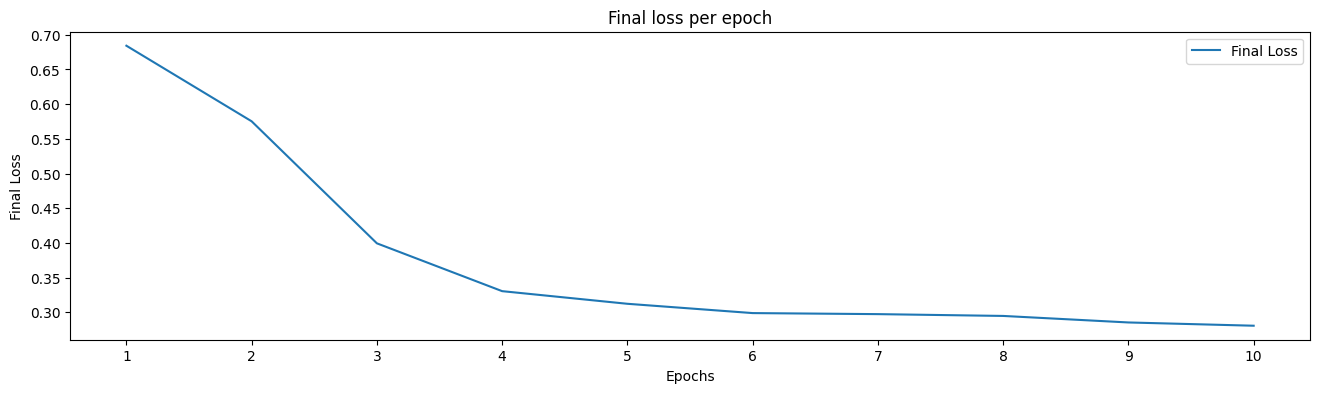

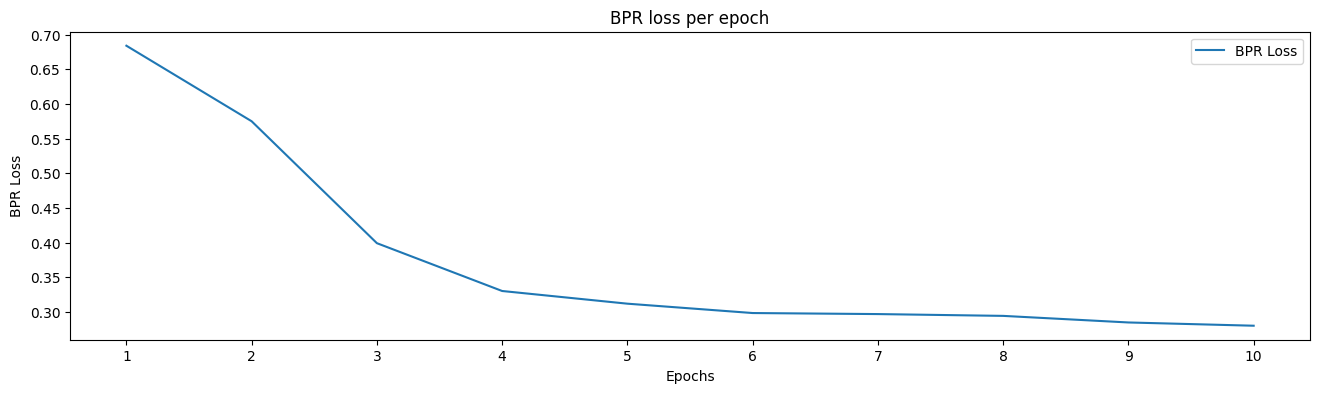

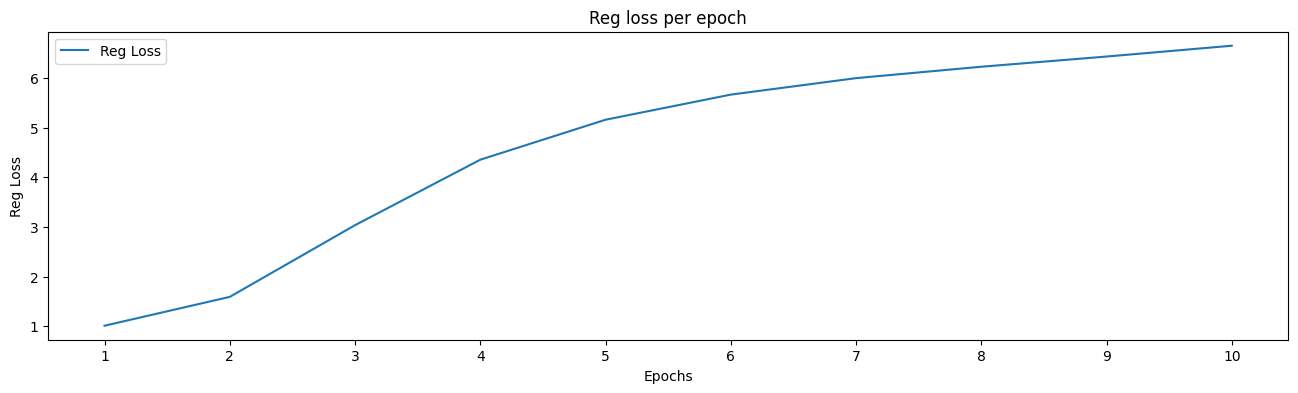

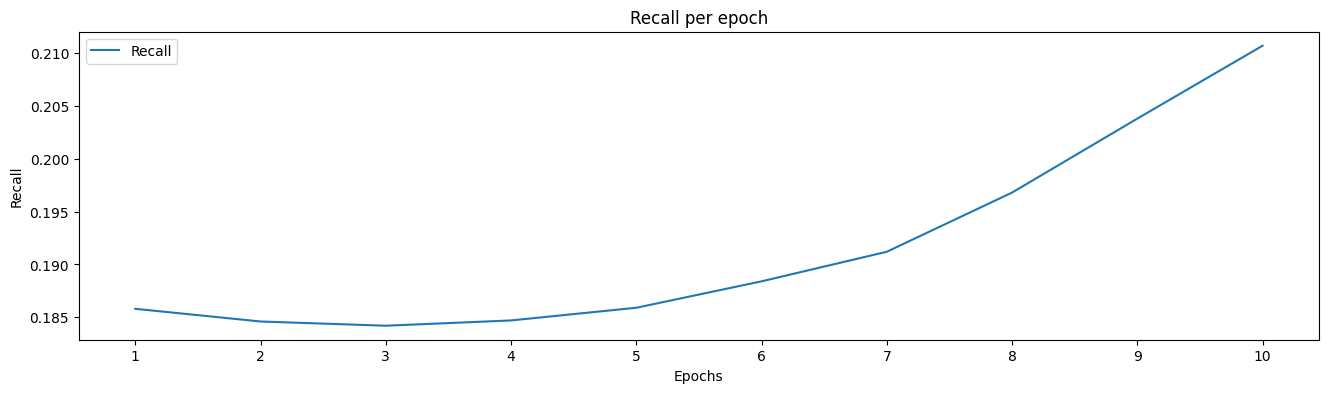

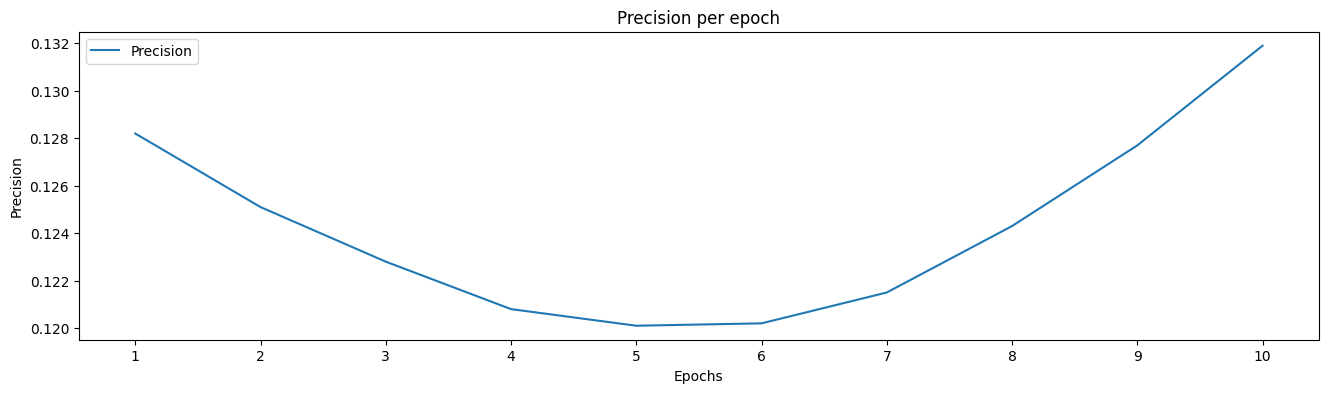

In [20]:
def plot_metrics(metrics: list, y_label: str, title: str):
    """
    Plot the training and evaluation metrics over epochs.

    Parameters:
        metrics (list): The list of metric values to plot.
        y_label (str): The label for the y-axis.
        title (str): The title of the plot.
    """
    epochs_range = range(1, EPOCHS + 1)

    plt.figure(figsize=(16, 4))
    plt.title(title)
    plt.plot(
        epochs_range, 
        np.array(metrics), 
        label=y_label,
    )
    plt.legend(loc="best")
    plt.xlabel("Epochs")
    plt.xticks(epochs_range)
    plt.ylabel(y_label)
    plt.show()

plot_metrics(light_loss, "Final Loss", "Final loss per epoch")
plot_metrics(light_bpr, "BPR Loss", "BPR loss per epoch")
plot_metrics(light_reg, "Reg Loss", "Reg loss per epoch")
plot_metrics(light_recall, "Recall", "Recall per epoch")
plot_metrics(light_precision, "Precision", "Precision per epoch")